In [1]:
import pandas as pd
import numpy as np
import random
import math
import os
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
import mars    #Module of the proposed method, it contains all functions and methods explained in the paper
from mars import MARS
import metrics    #Proposed metrics module, it contains all metric functions explained in the paper

DS = r'\MovieLens'
np.random.seed(1994)

C:\Users\MSI\anaconda3\envs\pyscience\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Get the directory where the data is
outdir = r"Data" + str(DS)

In [3]:
# Get the prices/profit of each item in the data set
df_price =pd.read_csv(outdir + "\item_profit.csv", engine='python',index_col=0,header=0)
price_df = df_price.copy()

In [4]:
#Get MovieLens1-M ratings
rating_df = pd.read_csv(outdir + r'\ratings.csv',header=0)

In [5]:
#MovieLens1-M data preprocesing
rating_df.drop('timestamp', axis=1,inplace=True)
users = rating_df['user_id'].nunique()
items = rating_df['movie_id'].nunique()
rating_df['user_id']=rating_df['user_id'].astype('category').cat.codes
rating_df['movie_id']=rating_df['movie_id'].astype('category').cat.codes

#Creation of sparce rating matrix of size (users x items)
rating_df = rating_df.to_numpy()
rating_matrix = np.zeros((users,items), dtype='int8')
for rating in rating_df:
    rating_matrix[rating[0]][rating[1]] = rating[2]
print(rating_matrix.shape)

(6040, 3706)


In [6]:
#Get predicted matrix (R^*)
nR = pd.read_csv(outdir + r'\MF_matrix.csv', header=None)
nR = nR.to_numpy()
print(nR.shape)

(6040, 3706)


In [7]:
#Compare actual vs predicted (R vs R^*) and get metrics
print('Accuracy R vs R^*')
print('Sparcity = ',rating_df.shape[0]/(users*items))
print('MAE = ',metrics.rating_mae(rating_matrix,nR))
print('RMSE = ',metrics.rating_rmse(rating_matrix,nR))

Accuracy R vs R^*
Sparcity =  0.044683625622312845
MAE =  0.6963651619429324
RMSE =  0.8887821070861819


In [8]:
#Set hyperparameters
th =3.5     #High rating threshold
tr = 4.5    #Ranking threshold
N=20        #TopN items
impact = 0.40    #Desired impact for the optimization process
acceptance = 0.02    #Tolerance for the optimization process
max_iter=20
max_iter2=20
lr=4

In [9]:
score_df = pd.DataFrame(columns=['Accuracy','Impact','NDCG','RMSE','MAE','Presicion','Avg. Profit','Items'])
sc_ind = []    #List of index, Name of each method.

In [10]:
#Proposed method (MARS)

profit_vec=price_df[['profit']].to_numpy()

#Create MARS model based on nR
mars_model = MARS(nR)
#Define and Transform the attributes
mars_model.to_rank(vectors=profit_vec, tensor=None)


#Training process to obtain the weights to get the desired impact or lower
print('Starting weights optimization process...')
mars_model.weights_optimization(impact=impact,tol=acceptance,W=2,tr=tr,N=N,
                                iterations=max_iter,s_iterations=max_iter2,lr=lr,uf=0.97,auf=1.5)
print('... finishing optimization process.')

#Get MARS model with the optimal weights
mars_rat_mat = mars_model.get_mars(tr,mars_model.weights)

#Recommend TopN items to all the users
rec_list_usersnR = mars.topN_rec(N,nR)    #TopN recommendations in the standard method
rec_list_users = mars.topN_rec(N,-mars_rat_mat)    #TopN recommendations in MARS method

#Obtain metrics comparing standard vs MARS
profitMARS, pful_MARS = metrics.get_average_profit(rec_list_users, price_df['profit'])
unique2 = np.unique(rec_list_users)
acc2 = metrics.accuracy_in_recommendations(rec_list_usersnR,rec_list_users)
rmse2, mae2 = metrics.rmse_mae(nR,rec_list_users)

#Save scores in Dataframe
score_df = score_df.append({'Accuracy': acc2,
                            'Impact':1-acc2,
                            'NDCG':metrics.get_NDCG(nR,rec_list_usersnR,rec_list_users)[0], 
                            'RMSE':rmse2,
                            'MAE':mae2,
                            'Presicion':metrics.presicion_in_recommendations(rating_matrix, rec_list_users,th)[0],
                            'Avg. Profit':profitMARS,
                            'Items': len(unique2)}, ignore_index=True)

w_sum = mars_model.weights.sum(axis=0)
sc_ind.append('MARS('+str(round(w_sum[0]/w_sum[1],4))+')')

Starting weights optimization process...
Cost=  0.43267384105960266 Impact=  0.6642301324503248
Cost=  0.4002152317880795 Impact=  0.6347516556291348
Cost=  0.35873344370860927 Impact=  0.5931705298013232
Cost=  0.3241473509933775 Impact=  0.5580215231788052
Cost=  0.3066556291390728 Impact=  0.5399668874172177
Cost=  0.3000496688741721 Impact=  0.5336423841059635
Cost=  0.2956870860927152 Impact=  0.5293460264900727
Cost=  0.29280629139072845 Impact=  0.5266804635761677
Cost=  0.29039735099337743 Impact=  0.524519867549679
Cost=  0.2887996688741722 Impact=  0.5231374172185544
Cost=  0.2874668874172185 Impact=  0.5216887417218669
Cost=  0.28681291390728475 Impact=  0.5211009933774962
12
... finishing optimization process.


In [11]:
#Standard method
sc_ind.append('Standard')

#Obtain metrics for standard model
uniquenR = np.unique(rec_list_usersnR)
profitnR, pful_nR = metrics.get_average_profit(rec_list_usersnR, price_df['profit'])
rmse1, mae1 = metrics.rmse_mae(nR,rec_list_usersnR)
acc = metrics.accuracy_in_recommendations(rec_list_usersnR,rec_list_usersnR)

#Save scores in Dataframe
score_df = score_df.append({'Accuracy':acc,
                            'Impact':1-acc,
                            'NDCG':metrics.get_NDCG(nR,rec_list_usersnR,rec_list_usersnR)[0],
                            'RMSE':rmse1,
                            'MAE':mae1,
                            'Presicion':metrics.presicion_in_recommendations(rating_matrix, rec_list_usersnR,th)[0],
                            'Avg. Profit':profitnR,
                            'Items': len(uniquenR)}, ignore_index=True)


In [12]:
#Method proposed by Jannach & Adomavicius (2017) (Baseline)
sc_ind.append('Baseline')

#Get baseline model
var = 'profit'
profit = price_df[var]
rank_x = np.array([1/(profit[i]+1) for i in range(len(profit))])
jan_rat_mat = mars.baseline(nR, rank_x, th,tr)

#TopN recommendations in baseline model
rec_list_jan = mars.topN_rec(N,-jan_rat_mat)

#Obtain metrics comparing baseline vs MARS
rmse1, mae1 = metrics.rmse_mae(nR,rec_list_jan)
profitJAN, pful_JAN = metrics.get_average_profit(rec_list_jan, price_df['profit'])
unique = np.unique(rec_list_jan)
acc = metrics.accuracy_in_recommendations(rec_list_usersnR,rec_list_jan)

#Save scores in Dataframe
score_df = score_df.append({'Accuracy': acc,
                            'Impact':1-acc,
                            'NDCG':metrics.get_NDCG(nR,rec_list_usersnR,rec_list_jan)[0],
                            'RMSE':rmse1,
                            'MAE':mae1,
                            'Presicion':metrics.presicion_in_recommendations(rating_matrix, rec_list_jan,th)[0],
                            'Avg. Profit':profitJAN,
                            'Items': len(unique)}, ignore_index=True)

In [13]:
#Show metrics scores dataframe
score_df.index = sc_ind
score_df

,Accuracy,Impact,NDCG,RMSE,MAE,Presicion,Avg. Profit,Items
MARS(2.9679),0.836821,0.163179,0.985710,6.263133,4.747417,0.905954,46.379051,2269.0
Standard,1.000000,0.000000,1.000000,0.000000,0.000000,0.903953,40.312550,2189.0
Baseline,0.305836,0.694164,0.884719,224.511339,188.383568,0.887083,64.982464,1839.0


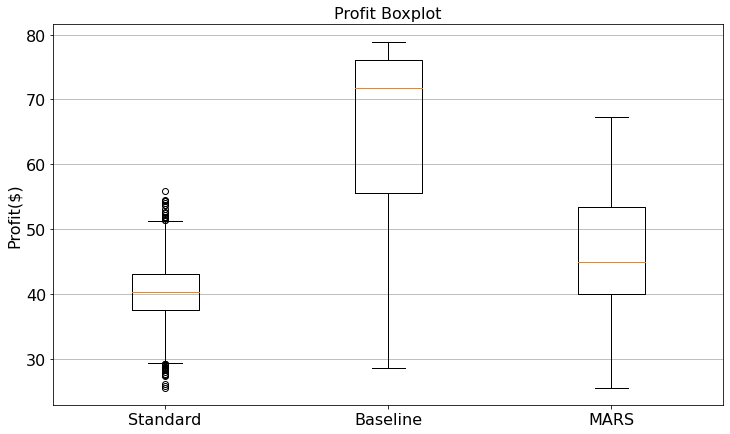

In [14]:
#Plot profit boxplot of the 3 methods
fs=16
plt.figure(figsize=(12,7))
plt.title('Profit Boxplot',fontsize=fs)
plt.boxplot([pful_nR,pful_JAN, pful_MARS],labels=['Standard','Baseline','MARS'])
plt.grid(True, axis='y')


plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.ylabel("Profit($)",fontsize=fs)
plt.show()

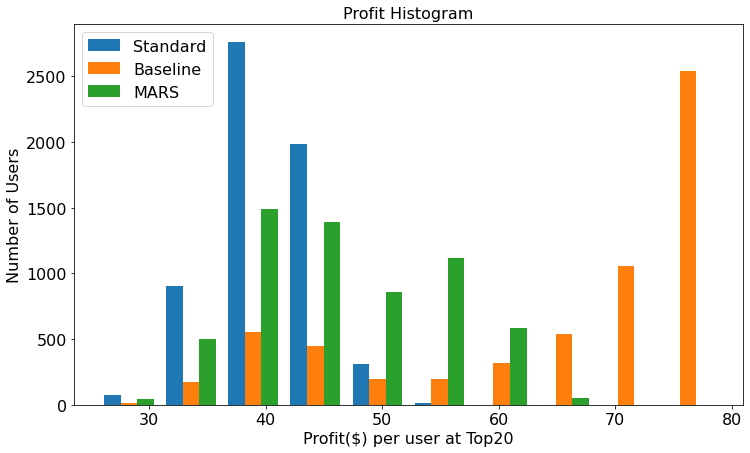

In [15]:
#Plot profit histogram of the 3 methods
plt.figure(figsize=(12,7))
plt.title('Profit Histogram',fontsize=fs)
plt.hist([pful_nR,pful_JAN,pful_MARS], bins=10,label = ['Standard','Baseline','MARS'])

plt.legend(fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.xlabel("Profit($) per user at Top"+str(N),fontsize=fs)
plt.ylabel("Number of Users",fontsize=fs) 
plt.show()